In [1]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu


In [2]:
import freyberg_setup
freyberg_setup.setup_pest_kr()
working_dir = freyberg_setup.WORKING_DIR_KR
pst_name = freyberg_setup.PST_NAME_KR

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'inschek', 'inschek.exe', 'kzone.ref', 'mf2005', 'mf2005.exe', 'mfnwt', 'mp6', 'mp6.exe', 'mpath.in', 'pest++.exe', 'pestchek', 'pestchek.exe', 'pestpp', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'sweep', 'sweep.exe', 'tempchek', 'tempchek.exe', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_kr
FloPy is using the

## First read in the PST file and find what are the starting values for K and R

In [3]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,1.0,0.75,1.25,rch,1.0,0.0,1
rch_1,rch_1,log,factor,1.0,0.75,1.25,rch,1.0,0.0,1
hk,hk,log,factor,5.0,0.50,50.00,hk,1.0,0.0,1


In [4]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.0
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name))

In [5]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name))
os.chdir('..')

In [6]:
inpst.phi_components

{'calflux': 0.0,
 'calhead': 1207.9102985264117,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

## We can import a function to explore a range of K and R values to make a response surface

In [7]:
import freyberg_response_surface as resurf

## First we should write out the control file with new bounds to bracket where values will be explored

## `rch_0` already spans the bounds we want, but `hk` is too wide

In [8]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
par = inpst.parameter_data

par.loc['hk', 'parlbnd'] = 3
par.loc['hk', 'parubnd'] = 12

inpst.write(os.path.join(working_dir,pst_name))

## Run the `run_respsurf` function to calculate the response surface

In [9]:
resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name)

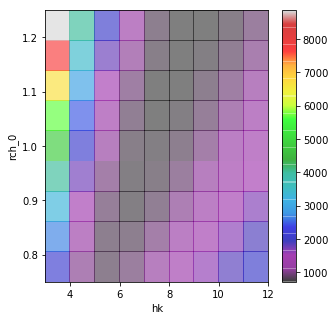

In [10]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);

In [77]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.parameter_data.loc['hk', 'parval1'] = 12
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8

inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name))

In [78]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name))
os.chdir('..')

### Now let's run PEST++ and see what we get for an estimate of the parameters
 * set NOPTMAX=-1
 * run PEST++

In [79]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.ipar')))
pars

,iteration,rch_0,rch_1,hk
0,0,0.8,1,12


In [80]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch_0,hk
rch_0,8258.693688,-7221.924547
hk,-7221.924547,6412.128032


In [81]:
R = covar.to_pearson()
R.df()

,rch_0,hk
rch_0,1.000000,-0.992422
hk,-0.992422,1.000000


In [89]:
sc.jco.to_dataframe().loc[inpst.nnz_obs_names]

,rch_0,hk
cr03c16_19700102,0.886282,-0.600416
cr03c10_19700102,4.067717,-3.766799
cr04c9_19700102,4.873227,-4.500495
cr10c2_19700102,12.275978,-11.781516
cr14c11_19700102,1.865253,-1.207386
cr16c17_19700102,1.151990,-0.965734
cr22c11_19700102,2.721080,-1.950695
cr23c16_19700102,0.913427,-0.835731
cr25c5_19700102,8.089972,-6.679732
cr27c7_19700102,6.398180,-4.878923


# What if we also have a calibration flux observation?

We can set this up by simply assigning non-zero weight to the observation in the group called `calflux`

We'll read in the PST file, change just that one value and write out a new PST file.

In [16]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [17]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,1.0,0.75,1.25,rch,1.0,0.0,1
rch_1,rch_1,fixed,factor,1.0,0.75,1.25,rch,1.0,0.0,1
hk,hk,log,factor,5.0,3.00,12.00,hk,1.0,0.0,1


In [18]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=10
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))

In [19]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r1.pst')))
os.chdir('..')

In [20]:
inpst.phi_components

{'calflux': 900221.44,
 'calhead': 1207.9102985264117,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [21]:
resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r1.pst'))

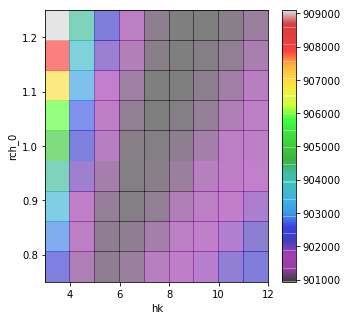

In [23]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r1.pst'));

In [73]:
def plot_response_surface(parnames, pstfile):
    p1,p2 = parnames
    df_in = pd.read_csv(os.path.join(working_dir, pstfile.replace('.pst',"sweep_in.csv")))
    df_out = pd.read_csv(os.path.join(working_dir, pstfile.replace('.pst',"sweep_out.csv")))
    resp_surf = np.zeros((10, 10))
    p1_values = df_in[p1].unique()
    p2_values = df_in[p2].unique()
    c = 0
    for i, v1 in enumerate(p1_values):
        for j, v2 in enumerate(p2_values):
            resp_surf[j, i] = df_out.loc[c, "phi"]
            c += 1
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    X, Y = np.meshgrid(p1_values, p2_values)
    #resp_surf = np.ma.masked_where(resp_surf > 5, resp_surf)
    p = ax.pcolor(X, Y, resp_surf, alpha=0.5, cmap="nipy_spectral")
    plt.colorbar(p)
    c = ax.contour(X, Y, resp_surf, levels=[0.1, 0.2, 0.5, 1, 2, 5], colors='k')
    plt.clabel(c)
    ax.set_xlim(p1_values.min(), p1_values.max())
    ax.set_ylim(p2_values.max(), p2_values.min())
    ax.set_xlabel(p1)
    ax.set_ylabel(p2)
    return resp_surf, X, Y, p1_values, p2_values

In [76]:
Y


array([[ 0.75      ,  0.75      ,  0.75      ,  0.75      ,  0.75      ,
         0.75      ,  0.75      ,  0.75      ,  0.75      ,  0.75      ],
       [ 0.80555556,  0.80555556,  0.80555556,  0.80555556,  0.80555556,
         0.80555556,  0.80555556,  0.80555556,  0.80555556,  0.80555556],
       [ 0.86111111,  0.86111111,  0.86111111,  0.86111111,  0.86111111,
         0.86111111,  0.86111111,  0.86111111,  0.86111111,  0.86111111],
       [ 0.91666667,  0.91666667,  0.91666667,  0.91666667,  0.91666667,
         0.91666667,  0.91666667,  0.91666667,  0.91666667,  0.91666667],
       [ 0.97222222,  0.97222222,  0.97222222,  0.97222222,  0.97222222,
         0.97222222,  0.97222222,  0.97222222,  0.97222222,  0.97222222],
       [ 1.02777778,  1.02777778,  1.02777778,  1.02777778,  1.02777778,
         1.02777778,  1.02777778,  1.02777778,  1.02777778,  1.02777778],
       [ 1.08333333,  1.08333333,  1.08333333,  1.08333333,  1.08333333,
         1.08333333,  1.08333333,  1.08333333

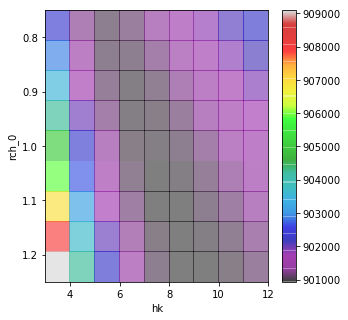

In [75]:
resp_surf, X, Y, p1_values, p2_values=plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r1.pst'))

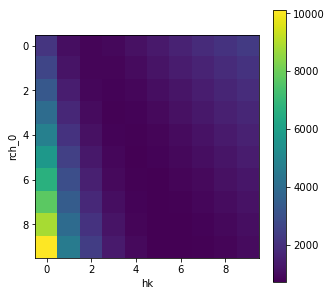

In [56]:
resp_surf, X, Y, p1_values, p2_values=plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name)

In [67]:
pst0p1.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch1,rch1,log,factor,0.000110,0.000079,0.000155,rch,1.0,0.0,1
rch2,rch2,fixed,factor,0.000094,0.000079,0.000155,rch,1.0,0.0,1
hk1,hk1,log,factor,8.000000,1.250000,80.000000,hk,1.0,0.0,1


In [68]:
pst0p1.control_data.noptmax=-1
pst0p1.parameter_data.loc['rch1','partrans']= 'log'
pst0p1.write('freyberg_w_flux0p1.pst')
shutil.copy2('freyberg_w_flux0p1.pst',os.path.join('base_resp_dir','freyberg_w_flux0p1.pst'))

'base_resp_dir\\freyberg_w_flux0p1.pst'

In [69]:
os.system('{0} freyberg_w_flux0p1.pst'.format(ppp))

0

### We can look at the final parameter values and their correlation

In [70]:
pars = pd.read_csv('freyberg_w_flux0p1.ipar')
pars

,iteration,rch1,rch2,hk1
0,0,0.00011,0.000094,8


In [71]:
sc = pyemu.Schur('freyberg_w_flux0p1.jcb')
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch1,hk1
rch1,1.004258e+06,46947.272660
hk1,4.694727e+04,2692.373346


In [72]:
R = covar.to_pearson()
R.df()

,rch1,hk1
rch1,1.000000,0.902859
hk1,0.902859,1.000000


In [73]:
# using the pandas set_value method
pst0p001=pyemu.Pst('freyberg.pst')
pst0p001.observation_data.loc['rivflux_cal','weight']=0.001
pst0p001.write('freyberg_w_flux0p001.pst')
shutil.copy2('freyberg_w_flux0p001.pst',os.path.join('base_resp_dir','freyberg_w_flux0p001.pst'))

'base_resp_dir\\freyberg_w_flux0p001.pst'

In [74]:
os.system('{0} freyberg_w_flux0p001.pst'.format(ppp))

0

In [75]:
pst0p001.phi_components

{'flux_cal': 0.8106769413759999,
 'flux_fore': 0.0,
 'head_cal': 98.1802598698,
 'head_fore': 0.0,
 'travel_fore': 0.0}

In [76]:
pyemu.utils.start_slaves('base_resp_dir',"{0}sweep".format(pref),"freyberg_w_flux0p001.pst",20,slave_root='.',port=4004,master_dir='.')

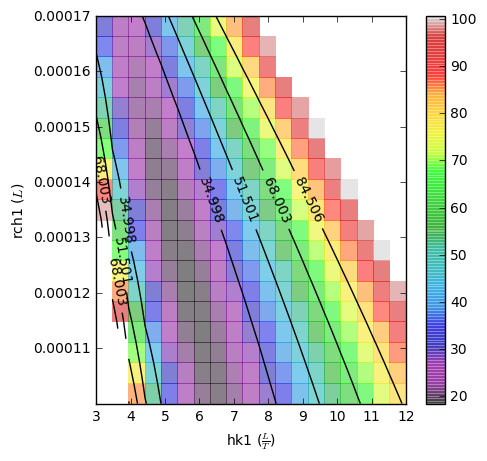

In [77]:
resp_plot()

In [78]:
pst0p001.control_data.noptmax=-1
pst0p001.write('freyberg_w_flux0p001.pst')

In [79]:
os.system('{0} freyberg_w_flux0p001.pst'.format(ppp))

0

In [80]:
pars = pd.read_csv('freyberg_w_flux0p001.ipar')
pars

,iteration,rch1,rch2,hk1
0,0,0.00011,0.000094,8


In [81]:
sc = pyemu.Schur('freyberg_w_flux0p001.jcb')
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch1,hk1
rch1,686.478674,-504.061408
hk1,-504.061408,448.757038


In [82]:
R = covar.to_pearson()
R.df()

,rch1,hk1
rch1,1.000000,-0.908164
hk1,-0.908164,1.000000


In [83]:
# using the pandas set_value method
pst0p01=pyemu.Pst('freyberg.pst')
pst0p01.observation_data.loc['rivflux_cal','weight']=0.01
pst0p01.write('freyberg_w_flux0p01.pst')
shutil.copy2('freyberg_w_flux0p01.pst',os.path.join('base_resp_dir','freyberg_w_flux0p01.pst'))

'base_resp_dir\\freyberg_w_flux0p01.pst'

In [84]:
os.system('{0} freyberg_w_flux0p01.pst'.format(ppp))

0

In [85]:
pst0p01.phi_components

{'flux_cal': 81.0676941376,
 'flux_fore': 0.0,
 'head_cal': 98.1802598698,
 'head_fore': 0.0,
 'travel_fore': 0.0}

In [86]:
pyemu.utils.start_slaves('base_resp_dir',"{0}sweep".format(pref),"freyberg_w_flux0p01.pst",20,slave_root='.',port=4004,master_dir='.')

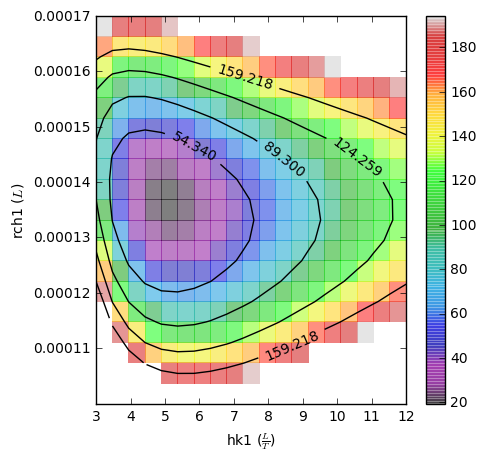

In [87]:
resp_plot()

In [88]:
pst0p01.control_data.noptmax=-1
pst0p01.write('freyberg_w_flux0p01.pst')
shutil.copy2('freyberg_w_flux0p01.pst',os.path.join('base_resp_dir','freyberg_w_flux0p01.pst'))

'base_resp_dir\\freyberg_w_flux0p01.pst'

In [89]:
os.system('{0} freyberg_w_flux0p01.pst'.format(ppp))

0

In [90]:
pars = pd.read_csv('freyberg_w_flux0p01.ipar')
pars

,iteration,rch1,rch2,hk1
0,0,0.00011,0.000094,8


In [91]:
sc = pyemu.Schur('freyberg_w_flux0p01.jcb')
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch1,hk1
rch1,10622.828927,-34.246220
hk1,-34.246220,470.971061


In [92]:
R = covar.to_pearson()
R.df()

,rch1,hk1
rch1,1.000000,-0.015311
hk1,-0.015311,1.000000


In [93]:
pst0p01.control_data.noptmax=15
pst0p01.write('freyberg_w_flux0p01.pst')

In [94]:
os.system('{0} freyberg_w_flux0p01.pst'.format(ppp))

0

In [95]:
sc = pyemu.Schur('freyberg_w_flux0p01.jcb')
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch1,hk1
rch1,16514.982071,-1017.190672
hk1,-1017.190672,1241.153388


In [96]:
R = covar.to_pearson()
R.df()

,rch1,hk1
rch1,1.000000,-0.224673
hk1,-0.224673,1.000000
